# 9. Problema de máxima diversidad

Implementar en Python un algoritmo evolutivo para el problema de máxima diversidad, tal y como se define en https://grafo.etsii.urjc.es/optsicom/mdp.html. Comparar las dos siguientes versiones del algoritmo para el manejo de las restricciones:

– **AE1: External feasibility first** (Tema 2, pág. 78). Dado que solo hay una restricción, las versiones max y sum de feasibility first externo descritas en el Tema 2 de la asignatura son equivalentes. El problema es de maximización, por lo que se transformará a un problema de minimización. La función objetivo resultante es la siguiente:

$\min F(x) = \begin{cases} 
-\sum\limits_{i=1}^{n-1} \sum\limits_{j=i+1}^{n} d_{ij} x_i x_j & \text{si } \sum\limits_{i=1}^n x_i = 0 \\
\lvert \sum\limits_{i=1}^n x_i - m \rvert & \text{en otro caso}
\end{cases}$

– **AE2: Algoritmo de reparo** (Tema 2, pág. 76).

Para las comparaciones, generar aleatoriamente 3 problemas de test con las siguientes características:

– **Problema de test 1**: $ n = 100, m = 10, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 2**: $ n = 150, m = 15, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 3**: $ n = 200, m = 20, K = 1, s_{ij} ∈ [0, 10]$.

Se realizará ajuste de parámetros con una **grid search** configurada de la
siguiente forma:

- Algoritmos evolutivos (proyectos 1 a 7, 9 y 10): grid search de 10x10, 3 repeticiones, probabilidad de cruce en el intervalo (0.0, 1.0], y probabilidad de mutación en el intervalo (0.0, 0.3], 100000 evaluaciones de la función objetivo en los proyectos 1 a 7, y 3000 evaluaciones en proyectos 9 y 10. En el proyecto 5, los operadores de mutación polinomial y “small” se aplican uno u otro con probabilidad 0.5.

Una vez identificados los valores de los parámetros, se realizarán **10 runs** con esos parámetros y diferentes semillas, con 300000 evaluaciones en los proyectos 1 a 8, y 10000 evaluaciones en los proyectos 9 y 10.

- Se reportará media, máximo, mínimo y desviación estándar para cada problema y algoritmo.

- Se realizará un ranking wins-losses de los resultados medios y de las diferencias estadísticamente significativas (Wilcoxon rank-sum test).

- Se entregará un documento Jupyter Notebook en Python con el código, comentarios, resultados, visualización gráfica de la evolución de los algoritmos (las 10 runs sobre el mismo gráfico), análisis y discusión de resultados y conclusiones.

# Algoritmo evolutivo para optimización con restricciones – External feasibility first – max version

### Descripción

<font size="4"> Algoritmo evolutivo para optimización continua con restricciones (minimización), enfoque "primero factibilidad", externo, versión max.

### Componentes

- Representación binaria.

- Manejo de restricciones con enfoque "primero factibilidad", externo, versión max

- Selección por torneo binario

- Muestreo estocástico con reemplazamiento

- Sustitución $(\mu+\lambda)$

- Elitista

- Cruce simple.

- Mutación bitflip.
   
### Comentarios
    
- Se requiere ordenar una población de $2 N$ individuos con los $\mu$ padres más los $\lambda$ hijos, $\mu=\lambda=N$.   
    
---

### Requerimientos

In [1]:
import numpy as np
import heapq 
from tqdm import tqdm
import matplotlib.pyplot as plt
import landscapes.single_objective as lso
from scipy.spatial import distance_matrix
import os
import pandas as pd
import csv
from scipy.stats import wilcoxon, mannwhitneyu
from statistics import mean

profiling = True # Poner a True para hacer profiling

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones. El número de evaluaciones será $2GN$.
- $N$: Tamaño de la población
- $random\_state$: Semilla para reproducibilidad
- $prob$: Probabilidades
  - $p\_c$: Probabilidad de cruce. El cruce será simple.
  - $p\_m$: Probabilidades de mutación. La mutación será bitflip.


### Definición del problema de optimización con restricciones (Máxima diversidad)
- $n$: Número de instancias del dataset (puntos de la nube de puntos).
- $k$: Dimensionalidad de la nube de puntos.
- $L$: Límite inferior de espacio muestral del dataset. 
- $U$: Límite superior de espacio muestral del dataset. Los puntos del dataset serán $s_i \in [L, U]^k \quad \forall i = 1, ..., n$.
- $f$: Función objetivo (máxima diversidad).
- $maxf$:  Máximo (aproximado) de la función $f$

In [2]:
# Problema de máxima diversidad

def diversity_obj(x, d):
    """
    Función objetivo del problema de máxima diversidad.
    x: representación binaria de un individuo. 
    d: matriz de distancias del dataset.
    """
    return -(x.T @ d @ x) # Cambiamos el signo para transformar el problema en uno de minimización

def maxDiversity_constraints(x, m):
    return np.array([np.abs(np.sum(x)-m)])

class diversity_problem:
    def __init__(self, n, m, k=1, L=0, U=10):
        self.n = n
        self.m = m
        self.k = k
        self.L = L
        self.U = U
        self.X = np.random.uniform(L, U, (n, k))     # Dataset de n puntos en [L, U]
        if k==1:
            # Ordena los puntos de menor a mayor
            self.X = np.sort(self.X, axis=0)
        self.d = np.triu(distance_matrix(self.X, self.X))   # Matriz de distancias de los puntos del dataset (n x n)
                                                            # Extraemos la parte triangular superior para evitar sumar distancias repetidas
                                                            
        self.f = lambda x: diversity_obj(x, self.d)  # Función objetivo
        self.g = lambda x: maxDiversity_constraints(x, m) # Restricciones
        self.maxf = 0

### Transformación del problema con restricciones en un problema sin restricciones – versión max

In [3]:
def transformed_problem(x,f,g,maxf):
    maxg = max(g(x))
    if maxg <= 0.0:
        return f(x)
    else:
        return maxf+maxg

### Definición de individuo

In [4]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n, dtype=int)
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [5]:
def InitializePopulation(P):
    for I in P:
        I.x[:] = np.random.randint(2, size=len(I.x))

### Función de evaluación

In [6]:
def evaluate_EFF(I,f,g,maxf):           
    I.f = transformed_problem(I.x,f,g,maxf)

### Copia de individuo

In [7]:
def copia(I1, I2):
    """
        Copia I2 en I1
    """
    np.copyto(I1.x, I2.x)
    I1.f = I2.f

### Selección por torneo binario

In [8]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Cruce
- Cruce con probabilidad $p\_c$ y:
    - cruce uniforme (con probabilidad $uniform\_crossover\_probability$)
    - cruce aritmético (con probabilidad $arithmetic\_crossover\_probability$)
    - cruce SBX en otro caso

In [9]:
def uniform_crossover(x1,x2):
    for l in range(x1.size):
        if np.random.random()<=0.5:
            x1[l], x2[l] = x2[l], x1[l] 
            
def simple_crossover(x1,x2):
    pos = np.random.randint(x1.size)
    x1[:], x2[:] = np.hstack((x1[:pos],x2[pos:])), np.hstack((x2[:pos],x1[pos:]))
        
def crossover(x1,x2,prob_cross): # Cruce simple
    if np.random.random()<=prob_cross:
        simple_crossover(x1,x2)

### Mutación
- Mutación con probabilidad $p\_m$ y:
    - mutación uniforme numerica (con probabilidad $uniform\_mutation\_probability$)
    - mutación small (con probabilidad $small\_mutation\_probability$) 
    - mutación polinomial en otro caso

In [10]:
def bitflip_mutation(x,p_m):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = 1-x[l]

def mutation(x,prob_mutation):
    bitflip_mutation(x, prob_mutation)

## Algoritmo de reparo

In [11]:
def maxDiversity_repair(x, m):
    """
    Reparación de la solución x para cumplir las restricciones del problema de máxima diversidad. Se realiza inplace.
    x: representación binaria de un individuo. 
    m: número de elementos a seleccionar.
    """
    v = np.sum(x)
    if v != m:
        if v > m:
            # Eliminar elemento
            x[np.random.choice(np.where(x == 1)[0], size=v-m, replace=False)] = 0
        else:
            # Añadir un elemento
            x[np.random.choice(np.where(x == 0)[0], size=m-v, replace=False)] = 1

def repair_and_evaluate(I, m, f):
    """
    Repara el individuo I si no cumple las restricciones y evalúa su función objetivo.
    """
    maxDiversity_repair(I.x, m)
    I.f = f(I.x)

### Progreso del algoritmo

In [12]:
def IniciaProgreso(P,G, g):
    best_outputs_f = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    best_outputs_g = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs_f,best_outputs_g,progression_bar, g)    
    return best_outputs_f,best_outputs_g,progression_bar
    
def ActualizaProgreso(P,gen,best_outputs_f,best_outputs_g,progression_bar, g):
    best_individuo = min(P)
    best_g = max(g(best_individuo.x))
    progression_bar.set_description("Generation: %s Objective: %s Feasibility: %s " % (str(gen), str(best_individuo.f), str(best_g)))
    best_outputs_f[gen] = best_individuo.f # Añadir mejor fitness (para visualización)
    best_outputs_g[gen] = best_g
    progression_bar.update(1)

### Algoritmo evolutivo

In [13]:
def EA(G,N,prob,problem,evaluate,random_state):
    """
    Algoritmo evolutivo para el problema de máxima diversidad con representación binaria y manejo de restricciones por External Feasibility First.
    G: número de generaciones.
    N: tamaño de la población.
    prob: probabilidad de cruce y de mutación.
    problem: instancia de la clase diversity_problem.
    evaluate: función de evaluación evaluate(I: individual, problem: diversity_problem).
    random_state: semilla para la generación de números aleatorios.
    """
    np.random.seed(random_state)
    
    p_c, p_m = prob
    
    # Aserciones
    
    assert G >= 1, "El número de evaluaciones debe ser mayor o igual que 1."  
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    
    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

    AssertProbability(p_c)
    
    AssertProbability(p_m)
    
    # Parámetros del problema
    n = problem.n
    m = problem.m
    f = problem.f
    g = problem.g
    maxf = problem.maxf

    # Crear población inicial con N individuos
    P = [Individuo(n) for _ in range(N)]
    InitializePopulation(P)
    
    # Evaluar población inicial
    for I in P:
        evaluate(I,problem)
    
    # Crear población auxilar 
    Q = [Individuo(n) for _ in range(2*N)]
    
    # Evoluciona durante G generaciones
    best_outputs_f,best_outputs_g,progression_bar = IniciaProgreso(P,G, problem.g)    
    for gen in range(1,G+1):
        for i in range(N):
            copia(Q[i],P[i])
        i=N
        while i < 2*N:
            copia(Q[i],binary_tournament_selection(P))
            copia(Q[i+1],binary_tournament_selection(P))
            crossover(Q[i].x,Q[i+1].x,p_c)
            mutation(Q[i].x,p_m)
            mutation(Q[i+1].x,p_m)
            evaluate(Q[i],problem)
            evaluate(Q[i+1],problem)
            i += 2  
        R = heapq.nsmallest(N,Q)
        for i in range(N):
            copia(P[i],R[i])
        ActualizaProgreso(P,gen,best_outputs_f,best_outputs_g,progression_bar, problem.g)
        # print([I.x for I in P])
    best_individuo = min(P)
    return best_outputs_f,best_outputs_g, best_individuo.f, best_individuo.x

def evaluate_AE1(I, problem):
    return evaluate_EFF(I, problem.f, problem.g, problem.maxf)

def evaluate_AE2(I, problem):
    return repair_and_evaluate(I, problem.m, problem.f)

## Definición de los problemas de test

Se generan aleatoriamente 3 problemas de test con las siguientes características:

– **Problema de test 1**: $ n = 100, m = 10, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 2**: $ n = 150, m = 15, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 3**: $ n = 200, m = 20, K = 1, s_{ij} ∈ [0, 10]$.

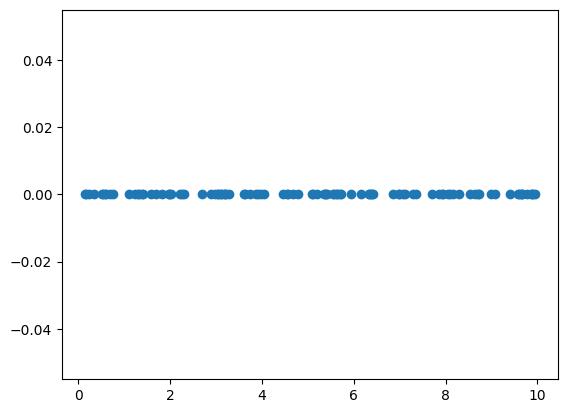

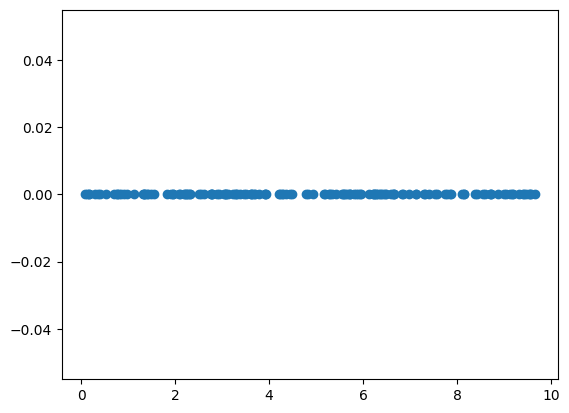

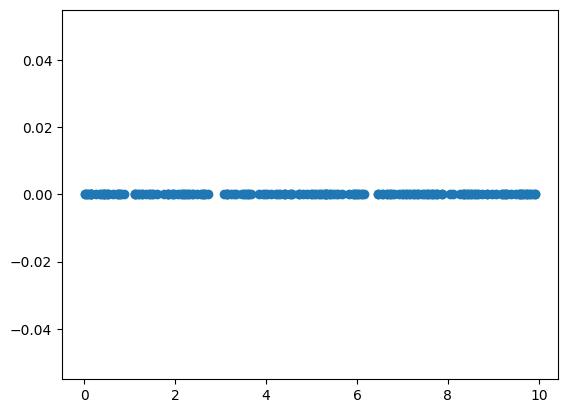

In [14]:
problems = [diversity_problem(100, 10), diversity_problem(150, 15), diversity_problem(200, 20)]

for problem in problems:
    plt.scatter(problem.X, np.zeros(problem.n))
    plt.show()

## Definición del Grid Search

- Se van a ajustar los siguientes parámetros del EA:
  - $p\_c$ (Probabilidad de cruce)
  - $p\_m$ (Probabilidad de mutación)

In [15]:
options = {'p_c': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
           'p_m': [1e-4,5e-4,1e-3,5e-3,0.01,0.05,0.1, 0.15, 0.2, 0.3]} \
        if not profiling else \
            {'p_c': [0.7, 0.8], 'p_m': [0.01, 0.05]}

In [16]:
def GridSearchEA(options, n_repeat, G, N, problem, evaluate):    
    best_score = float('inf')
    best_options = None
    for p_c in options['p_c']:
        for p_m in options['p_m']:
            score = np.zeros(n_repeat)
            print("p_c:",p_c," p_m:",p_m)
            for i in range(n_repeat):
                prob = p_c, p_m
                _, _, score[i], _ = EA(G, N, prob, problem, evaluate, random_state = i)
            scoreMean = score.mean()
            print("Score Mean: ",scoreMean)
            print("")
            if scoreMean < best_score:
                best_score = scoreMean
                best_options = {'p_c': p_c, 'p_m': p_m}
    return best_score, best_options

### Ejecución del Grid Search

In [17]:
# Crea un directorio para guardar archivos con los resultados
results_dir = 'cbio_p9_results' if not profiling else 'cbio_p9_results_profiling'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [18]:
N = 100
evals = 200000 # Aumentamos el número de evaluaciones
G = evals//(2*N) if not profiling else 50

n_repeat = 3


best_scores = []
best_options_list = []

evaluation_functions = [evaluate_AE1, evaluate_AE2]
algorithm_names = ['AE1', 'AE2']

for evaluate, algorithm_name in zip(evaluation_functions, algorithm_names):
    for nproblem, problem in enumerate(problems):
        print("ALGORITMO: ", algorithm_name)
        print("PROBLEMA DE TEST ", nproblem+1)
        print("n: ", problem.n, " m: ", problem.m, " k: ", problem.k, " L: ", problem.L, " U: ", problem.U)

        best_score, best_options = GridSearchEA(options=options,n_repeat=n_repeat,G=G,N=N,evaluate=evaluate,problem=problem)

        best_scores.append(best_score)
        best_options_list.append(best_options)
        
        print("BEST:")
        print(best_score)
        print(best_options)

df = pd.DataFrame(columns=['algorithm', 'problem', 'n', 'm', 'k', 'L', 'U', 'gs_best_score', 'best_options'])
df['algorithm'] = [algorithm_name for algorithm_name in algorithm_names for _ in range(len(problems))]
df['problem'] = list(range(1, len(problems)+1)) * 2
df['n'] = [problem.n for problem in problems] * 2
df['m'] = [problem.m for problem in problems] * 2
df['k'] = [problem.k for problem in problems] * 2
df['L'] = [problem.L for problem in problems] * 2
df['U'] = [problem.U for problem in problems] * 2
df['gs_best_score'] = best_scores
df['best_options'] = best_options_list

df.to_csv(os.path.join(results_dir, f'cbio_p9_grid_search.csv'), index=False)

ALGORITMO:  AE1
PROBLEMA DE TEST  1
n:  100  m:  10  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -215.818146805577 Feasibility: 0 : : 51it [00:01, 35.38it/s]  
Generation: 50 Objective: -207.39943735971855 Feasibility: 0 : : 51it [00:01, 33.38it/s]
Generation: 50 Objective: -216.46757975450788 Feasibility: 0 : : 51it [00:01, 41.87it/s]


Score Mean:  -213.22838797326781

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -198.7047797820953 Feasibility: 0 : : 51it [00:00, 55.88it/s] 
Generation: 50 Objective: -189.3430502419709 Feasibility: 0 : : 51it [00:00, 51.61it/s] 
Generation: 50 Objective: -209.33309359146875 Feasibility: 0 : : 51it [00:00, 52.78it/s]


Score Mean:  -199.1269745385117

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -223.92185504603142 Feasibility: 0 : : 51it [00:01, 37.32it/s]
Generation: 50 Objective: -232.45665718464164 Feasibility: 0 : : 51it [00:01, 38.87it/s]
Generation: 50 Objective: -226.17410053211498 Feasibility: 0 : : 51it [00:01, 37.71it/s]


Score Mean:  -227.51753758759602

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -189.51368809411105 Feasibility: 0 : : 51it [00:00, 54.11it/s]
Generation: 50 Objective: -187.97888726624126 Feasibility: 0 : : 51it [00:00, 55.97it/s]
Generation: 50 Objective: -202.39789463598197 Feasibility: 0 : : 51it [00:00, 51.88it/s]


Score Mean:  -193.29682333211144

BEST:
-227.51753758759602
{'p_c': 0.8, 'p_m': 0.01}
ALGORITMO:  AE1
PROBLEMA DE TEST  2
n:  150  m:  15  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -398.4089564769024 Feasibility: 0 : : 51it [00:01, 35.90it/s] 
Generation: 50 Objective: -407.4216527069839 Feasibility: 0 : : 51it [00:01, 39.09it/s] 
Generation: 50 Objective: -468.7049021328797 Feasibility: 0 : : 51it [00:01, 27.53it/s] 


Score Mean:  -424.84517043892197

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:01, 45.87it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:01, 44.62it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 51.38it/s]  


Score Mean:  3.6666666666666665

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -417.7508913373344 Feasibility: 0 : : 51it [00:01, 35.66it/s] 
Generation: 50 Objective: -408.8656303437016 Feasibility: 0 : : 51it [00:01, 25.77it/s] 
Generation: 50 Objective: -412.54703859866515 Feasibility: 0 : : 51it [00:02, 24.49it/s]


Score Mean:  -413.05452009323363

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:01, 48.55it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 53.88it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 58.90it/s]  


Score Mean:  3.0

BEST:
-424.84517043892197
{'p_c': 0.7, 'p_m': 0.01}
ALGORITMO:  AE1
PROBLEMA DE TEST  3
n:  200  m:  20  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -730.0126460111603 Feasibility: 0 : : 51it [00:00, 53.03it/s]
Generation: 50 Objective: -779.4196011715387 Feasibility: 0 : : 51it [00:01, 49.62it/s]
Generation: 50 Objective: -734.3430614404178 Feasibility: 0 : : 51it [00:01, 50.96it/s]


Score Mean:  -747.9251028743723

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 54.46it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 55.64it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 57.04it/s]  


Score Mean:  10.333333333333334

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -756.8568997196699 Feasibility: 0 : : 51it [00:00, 53.61it/s]
Generation: 50 Objective: -684.2533747153198 Feasibility: 0 : : 51it [00:01, 47.18it/s]
Generation: 50 Objective: -770.6689696999174 Feasibility: 0 : : 51it [00:01, 47.68it/s]


Score Mean:  -737.259748044969

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:01, 50.85it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 52.39it/s]  
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 54.40it/s]


Score Mean:  12.666666666666666

BEST:
-747.9251028743723
{'p_c': 0.7, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  1
n:  100  m:  10  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -242.45557891157992 Feasibility: 0 : : 51it [00:02, 21.34it/s]
Generation: 50 Objective: -242.45557891157992 Feasibility: 0 : : 51it [00:02, 19.22it/s]
Generation: 50 Objective: -242.36733019498186 Feasibility: 0 : : 51it [00:03, 14.39it/s]


Score Mean:  -242.4261626727139

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -237.88946091350044 Feasibility: 0 : : 51it [00:02, 19.97it/s]
Generation: 50 Objective: -240.25788983000794 Feasibility: 0 : : 51it [00:02, 20.89it/s]
Generation: 50 Objective: -237.65308780765957 Feasibility: 0 : : 51it [00:02, 20.18it/s]


Score Mean:  -238.60014618372261

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -242.3474156408733 Feasibility: 0 : : 51it [00:03, 15.25it/s] 
Generation: 50 Objective: -242.47549346568843 Feasibility: 0 : : 51it [00:03, 16.69it/s]
Generation: 50 Objective: -242.28975588987927 Feasibility: 0 : : 51it [00:03, 16.10it/s]


Score Mean:  -242.37088833214702

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -239.79196376072406 Feasibility: 0 : : 51it [00:02, 18.05it/s]
Generation: 50 Objective: -239.97913632348144 Feasibility: 0 : : 51it [00:03, 14.41it/s]
Generation: 50 Objective: -239.48699953438177 Feasibility: 0 : : 51it [00:02, 17.37it/s]


Score Mean:  -239.75269987286242

BEST:
-242.4261626727139
{'p_c': 0.7, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  2
n:  150  m:  15  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -525.049264331173 Feasibility: 0 : : 51it [00:02, 19.51it/s]  
Generation: 50 Objective: -525.3624170296503 Feasibility: 0 : : 51it [00:02, 19.96it/s] 
Generation: 50 Objective: -525.3935441457509 Feasibility: 0 : : 51it [00:02, 20.50it/s] 


Score Mean:  -525.2684085021914

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -515.5374216075197 Feasibility: 0 : : 51it [00:02, 19.12it/s] 
Generation: 50 Objective: -514.8989887196283 Feasibility: 0 : : 51it [00:02, 19.07it/s] 
Generation: 50 Objective: -504.38589140879776 Feasibility: 0 : : 51it [00:02, 21.12it/s]


Score Mean:  -511.6074339119819

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -525.3623773505071 Feasibility: 0 : : 51it [00:02, 18.35it/s] 
Generation: 50 Objective: -526.1660711650547 Feasibility: 0 : : 51it [00:03, 15.17it/s]
Generation: 50 Objective: -526.0160110994852 Feasibility: 0 : : 51it [00:02, 19.10it/s] 


Score Mean:  -525.8481532050157

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -514.7797189600716 Feasibility: 0 : : 51it [00:03, 14.89it/s] 
Generation: 50 Objective: -505.20469985342385 Feasibility: 0 : : 51it [00:02, 20.37it/s]
Generation: 50 Objective: -505.5961038689526 Feasibility: 0 : : 51it [00:03, 16.69it/s]


Score Mean:  -508.5268408941494

BEST:
-525.8481532050157
{'p_c': 0.8, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  3
n:  200  m:  20  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -971.3624652005749 Feasibility: 0 : : 51it [00:02, 17.79it/s]
Generation: 50 Objective: -969.9381012900236 Feasibility: 0 : : 51it [00:03, 15.41it/s]
Generation: 50 Objective: -972.2737248041673 Feasibility: 0 : : 51it [00:03, 16.93it/s]


Score Mean:  -971.1914304315886

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -942.471801554218 Feasibility: 0 : : 51it [00:03, 15.98it/s] 
Generation: 50 Objective: -932.1766643933777 Feasibility: 0 : : 51it [00:02, 18.49it/s]
Generation: 50 Objective: -939.1668816218344 Feasibility: 0 : : 51it [00:02, 17.39it/s]


Score Mean:  -937.93844918981

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -971.4110788007883 Feasibility: 0 : : 51it [00:02, 18.58it/s]
Generation: 50 Objective: -973.3847847316615 Feasibility: 0 : : 51it [00:03, 14.50it/s]
Generation: 50 Objective: -970.8372509590992 Feasibility: 0 : : 51it [00:03, 13.04it/s]


Score Mean:  -971.8777048305163

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -941.5594501581274 Feasibility: 0 : : 51it [00:02, 17.42it/s]
Generation: 50 Objective: -950.4919413308958 Feasibility: 0 : : 51it [00:02, 19.73it/s]
Generation: 50 Objective: -936.1459193910998 Feasibility: 0 : : 51it [00:02, 18.35it/s]

Score Mean:  -942.732436960041

BEST:
-971.8777048305163
{'p_c': 0.8, 'p_m': 0.01}


In [19]:
df

,algorithm,problem,n,m,k,L,U,gs_best_score,best_options
0,AE1,1,100,10,1,0,10,-227.517538,"{'p_c': 0.8, 'p_m': 0.01}"
1,AE1,2,150,15,1,0,10,-424.845170,"{'p_c': 0.7, 'p_m': 0.01}"
2,AE1,3,200,20,1,0,10,-747.925103,"{'p_c': 0.7, 'p_m': 0.01}"
3,AE2,1,100,10,1,0,10,-242.426163,"{'p_c': 0.7, 'p_m': 0.01}"
4,AE2,2,150,15,1,0,10,-525.848153,"{'p_c': 0.8, 'p_m': 0.01}"
5,AE2,3,200,20,1,0,10,-971.877705,"{'p_c': 0.8, 'p_m': 0.01}"


### Ejecución del algoritmo evolutivo con los parámetros ajustados

In [20]:
# Ejecutar 10 runs, con mayor número de generaciones, con los mejores parámetros y reportar media, máximo, mínimo y desviación estándar
# Guardar en un fichero los fitness de las 10 runs para los test estadísticos

N = 100
evals = 2000000
G = evals//(2*N) if not profiling else 100
n_repeat = 10 if not profiling else 3

best_outputs_f = np.full((len(evaluation_functions), len(problems), n_repeat), None, dtype=object)
best_outputs_g = np.full((len(evaluation_functions), len(problems), n_repeat), None, dtype=object)
best_fitness = np.zeros((len(evaluation_functions), len(problems), n_repeat))
best_individuos = np.full((len(evaluation_functions), len(problems), n_repeat), None, dtype=object)

for nalgorithm, evaluate in enumerate(evaluation_functions):
    for nproblem, problem in enumerate(problems):
        p_c = best_options_list[nalgorithm*len(problems) + nproblem]['p_c']
        p_m = best_options_list[nalgorithm*len(problems) + nproblem]['p_m']
        prob = p_c, p_m
        print("p_c:",p_c," p_m:",p_m)
        for i in range(n_repeat):
            best_outputs_f[nalgorithm, nproblem, i], best_outputs_g[nalgorithm, nproblem, i], best_fitness[nalgorithm, nproblem, i], best_individuos[nalgorithm, nproblem, i] = EA(G,N,prob,problem,evaluate,random_state=i)
        
        print("ALGORITMO ", algorithm_names[nalgorithm])
        print("TEST ", nproblem+1)
        print("Media: ",np.mean(best_fitness))
        print("Máximo: ",np.max(best_fitness))
        print("Mínimo: ",np.min(best_fitness))
        print("Desviación estándar: ",np.std(best_fitness))

# Convert best_fitness and best_individuos to dataframe
best_fitness_df = pd.DataFrame(columns=['algorithm', 'problem', 'run', 'fitness'])
best_individuos_df = pd.DataFrame(columns=['algorithm', 'problem', 'run', 'individuo'])
for nalgorithm, algorithm_name in enumerate(algorithm_names):
    for nproblem, problem in enumerate(problems):
        for i in range(n_repeat):
            best_fitness_df = pd.concat([best_fitness_df, pd.DataFrame([{
                'algorithm': algorithm_name, 
                'problem': nproblem+1, 
                'run': i+1, 
                'fitness': best_fitness[nalgorithm, nproblem, i]
            }])], ignore_index=True)            
            best_individuos_df = pd.concat([best_individuos_df, pd.DataFrame([{
                'algorithm': algorithm_name, 
                'problem': nproblem+1, 
                'run': i+1, 
                'individuo': best_individuos[nalgorithm, nproblem, i
            ]}])], ignore_index=True)

best_fitness_df.to_csv(os.path.join(results_dir, 'cbio_p9_best_fitness.csv'), index=False)
best_individuos_df.to_csv(os.path.join(results_dir, 'cbio_p9_best_individuos.csv'), index=False)

p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -236.57210388258517 Feasibility: 0 : : 101it [00:02, 35.15it/s]
Generation: 100 Objective: -237.41044970731522 Feasibility: 0 : : 101it [00:02, 38.88it/s]
Generation: 100 Objective: -242.1169175828714 Feasibility: 0 : : 101it [00:02, 37.80it/s]


ALGORITMO  AE1
TEST  1
Media:  -39.78330395404287
Máximo:  0.0
Mínimo:  -242.1169175828714
Desviación estándar:  88.96375067735845
p_c: 0.7  p_m: 0.01


Generation: 100 Objective: -508.40471209425124 Feasibility: 0 : : 101it [00:02, 38.43it/s]
Generation: 100 Objective: -501.5145934431023 Feasibility: 0 : : 101it [00:02, 38.49it/s]
Generation: 100 Objective: -515.2707370739595 Feasibility: 0 : : 101it [00:02, 38.02it/s]


ALGORITMO  AE1
TEST  2
Media:  -124.51608409911584
Máximo:  0.0
Mínimo:  -515.2707370739595
Desviación estándar:  192.55161809491614
p_c: 0.7  p_m: 0.01


Generation: 100 Objective: -899.7438076492577 Feasibility: 0 : : 101it [00:02, 38.97it/s]
Generation: 100 Objective: -878.535065254167 Feasibility: 0 : : 101it [00:02, 38.34it/s]
Generation: 100 Objective: -901.9428259454829 Feasibility: 0 : : 101it [00:02, 36.81it/s]


ALGORITMO  AE1
TEST  3
Media:  -273.4172895907218
Máximo:  0.0
Mínimo:  -901.9428259454829
Desviación estándar:  332.9734924431895
p_c: 0.7  p_m: 0.01


Generation: 100 Objective: -242.47549346568843 Feasibility: 0 : : 101it [00:03, 32.68it/s]
Generation: 100 Objective: -242.47549346568843 Feasibility: 0 : : 101it [00:03, 31.66it/s]
Generation: 100 Objective: -242.47549346568843 Feasibility: 0 : : 101it [00:03, 30.99it/s]


ALGORITMO  AE2
TEST  1
Media:  -313.8298718350032
Máximo:  0.0
Mínimo:  -901.9428259454829
Desviación estándar:  311.3490537690482
p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -526.1660711650547 Feasibility: 0 : : 101it [00:04, 25.20it/s]
Generation: 100 Objective: -526.1660711650547 Feasibility: 0 : : 101it [00:04, 25.02it/s]
Generation: 100 Objective: -526.1660711650547 Feasibility: 0 : : 101it [00:04, 25.18it/s]


ALGORITMO  AE2
TEST  2
Media:  -401.524217029179
Máximo:  0.0
Mínimo:  -901.9428259454829
Desviación estándar:  283.4563704561473
p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -975.6368013671683 Feasibility: 0 : : 101it [00:04, 23.06it/s]
Generation: 100 Objective: -976.1049273855634 Feasibility: 0 : : 101it [00:04, 20.83it/s]
Generation: 100 Objective: -976.3597007778335 Feasibility: 0 : : 101it [00:04, 22.42it/s]


ALGORITMO  AE2
TEST  3
Media:  -564.196518669766
Máximo:  -236.57210388258517
Mínimo:  -976.3597007778335
Desviación estándar:  286.40038477269235


### Visualización de la evolución del algoritmo

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_0.png.png


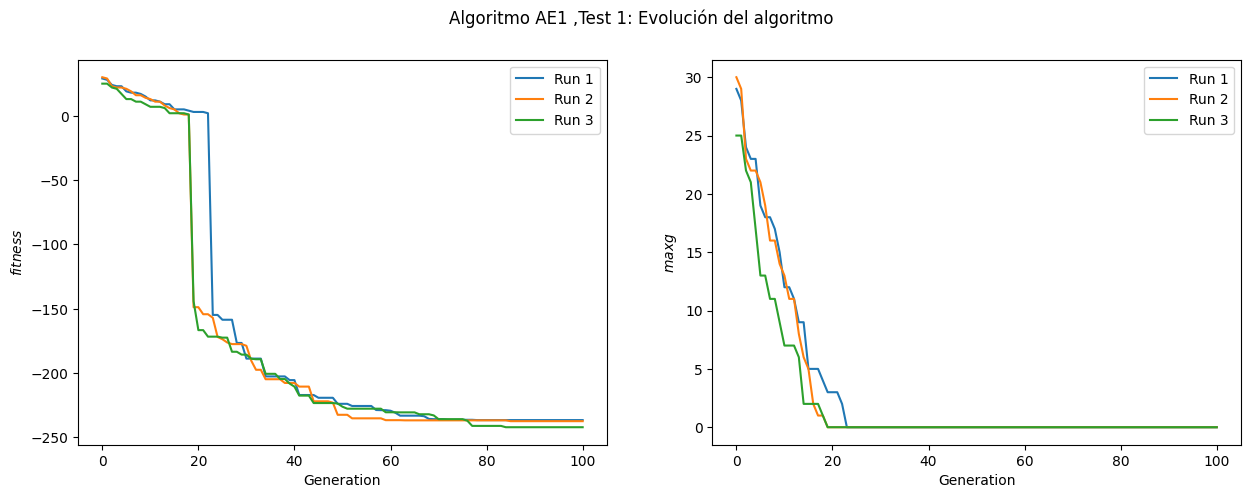

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_1.png.png


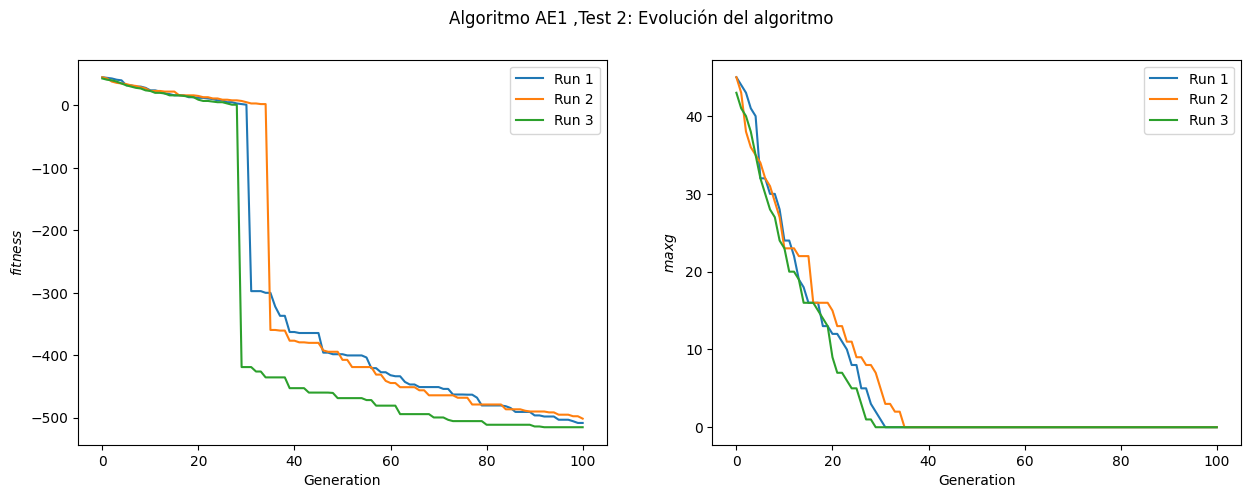

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_2.png.png


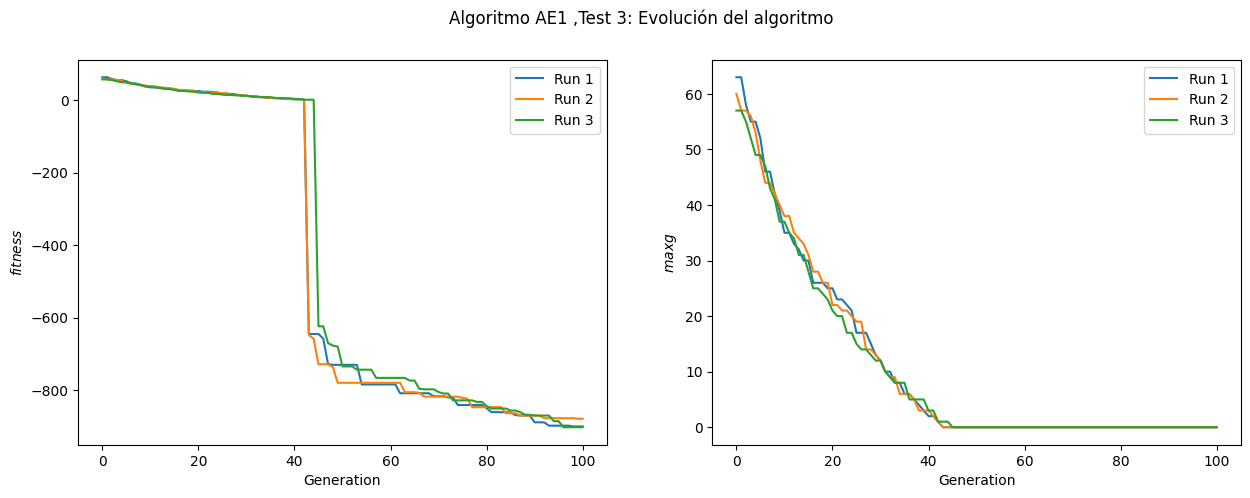

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_0.png.png


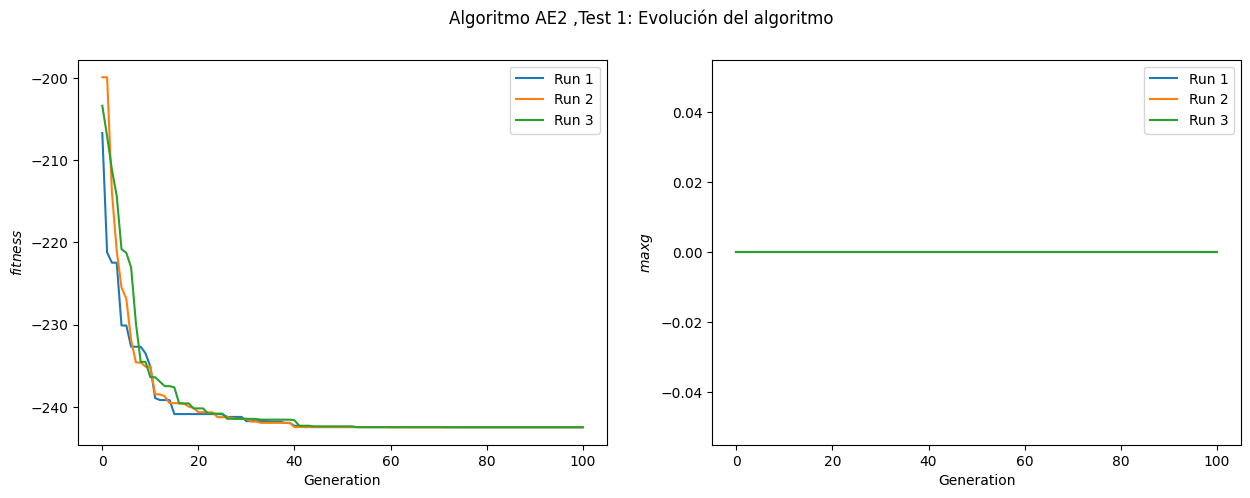

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_1.png.png


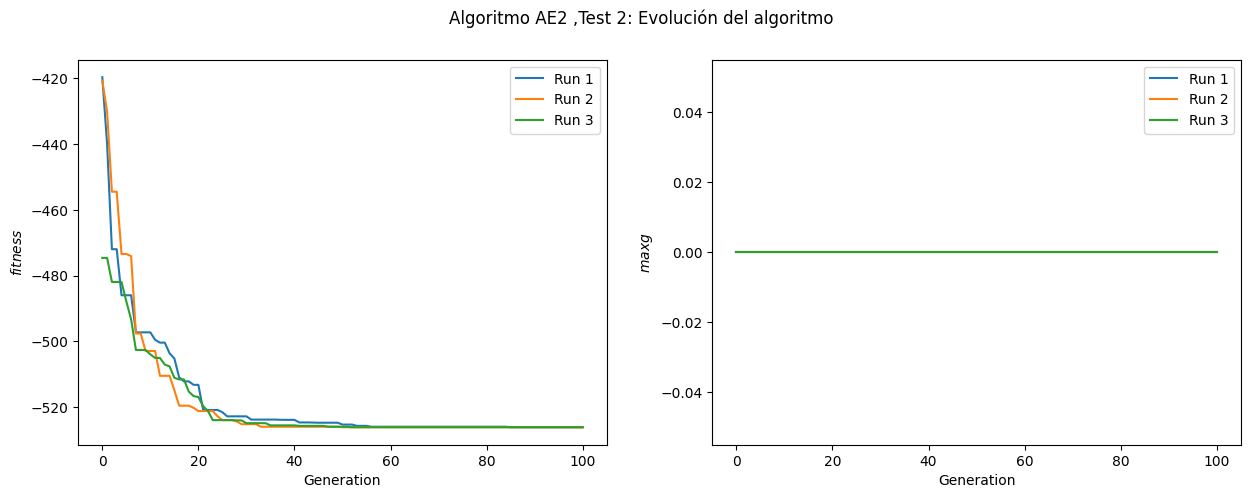

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_2.png.png


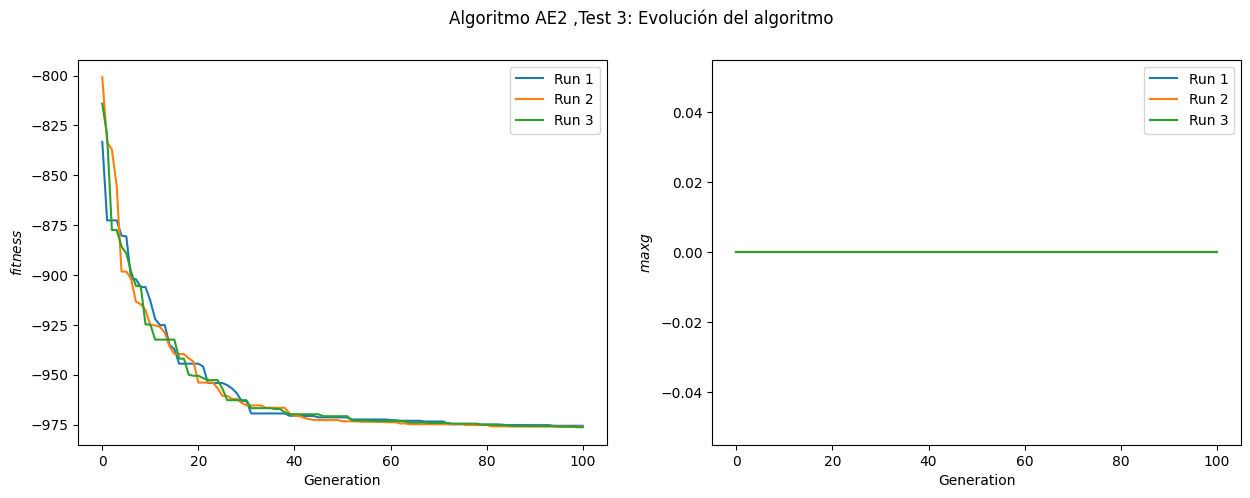

In [21]:
def VisualizaEvolucion(outputs, ylabels, title="Algorithm Evolution", file_prefix=None):
    """
    Muestra una única gráfica con todas las ejecuciones de best_outputs en distintos colores.
    
    Parámetros:
    - best_outputs: np.array de listas con la evolución del fitness en cada run.
    - ylabel: Etiqueta para el eje Y.
    - file_prefix: Prefijo del archivo si se desea guardar la figura.
    """
    
    fig, axes = plt.subplots(nrows=1, ncols = len(outputs), figsize=(15, 5))
    fig.suptitle(title)  # Título común para ambas gráficas
    
    for i, output in enumerate(outputs):
        for j in range(output.shape[0]):
            axes[i].plot(output[j], label=f"Run {j+1}")
            axes[i].set_xlabel("Generation")
            axes[i].set_ylabel(ylabels[i])
            axes[i].legend()
    
    plt.xlabel("Generation")
    plt.legend()
    
    if file_prefix is not None:
        file_path = f"{file_prefix}.png"
        plt.savefig(file_path)
        print(f"Saved: {file_path}")
    
    plt.show()

for nalgorithm, name in enumerate(algorithm_names):
    for nproblem in range(len(problems)):
        VisualizaEvolucion([best_outputs_f[nalgorithm, nproblem, :], best_outputs_g[nalgorithm,nproblem, :]], ["$fitness$", "$maxg$"], f"Algoritmo {name} ,Test {nproblem+1}: Evolución del algoritmo", os.path.join(results_dir, f"EvolutionMuLambdaObjective_{nproblem}.png"))


## Solución de cada problema

Al ser $K=1$, se tiene que la solución óptima al problema cumple que, si $s_1 \le \cdots \le s_n$, la solución es de la forma:

$$x_i = \begin{cases}
    1 & \text{, si } i \le p \lor i \ge n-m+p \\
    0 & \text{, en otro caso}
\end{cases}$$

para algún $1 \le p \le m-1$. Por tanto, podemos buscar la solución óptima de entre las $m-1$ posibilidades.

In [22]:
# Obtiene la solución de cada problema
def solve(problem):
    sol = np.zeros(problem.n, dtype=int)
    minf = 0
    for i in range(1, problem.m):
        x = np.zeros(problem.n, dtype=int)
        x[:i] = 1
        x[problem.n-problem.m+i:] = 1
        f = problem.f(x)
        if f < minf:
            minf = f
            sol = x
    return minf, sol

solutions = [solve(problem) for problem in problems]

for i, (f, sol) in enumerate(solutions):
    print("PROBLEMA ", i)
    print("Valor objetivo: ", f)
    print("Valor obtenido: ", best_fitness[1, i, 0])
    print("Solución: ", sol)
    #print(best_individuos[1, i, 0])

PROBLEMA  0
Valor objetivo:  -242.47549346568843
Valor obtenido:  -242.47549346568843
Solución:  [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
PROBLEMA  1
Valor objetivo:  -526.1660711650547
Valor obtenido:  -526.1660711650547
Solución:  [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1]
PROBLEMA  2
Valor objetivo:  -976.5144151618861
Valor obtenido:  -975.6368013671683
Solución:  [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

# TODO: ADAPTAR. Test estadísticos

### Descripción

<font size="4"> Comparación de algoritmos para minimización/maximización utilizando test estadísticos.
    
### Componentes
    
- <font size="3"> Se requiere un fichero csv separado para cada problema. En cada fichero csv, las columnas representan los algoritmos a comparar y las filas son las muestras de los resultados. Las cabeceras de todos los ficheros csv deben ser las mismas.
    
- <font size="3"> Se calculan ranking wins - loss para los siguientes test estadísticos:

    - <font size="3"> Mann-Whitney U test (Wilconxon rank-sum test), apropiado para la comparación  de algoritmos probabilistas ejecutados múltiples veces con distintas semillas (muestras independientes).

    - <font size="3"> Wilcoxon signed-rank test, apropiado para la comparación de algoritmos de aprendizaje evaluados en $k$-fold cross-validation, $n$ repeticiones (muestras pareadas).

- <font size="3"> Se calcula también el ranking wins - loss de los resultados medios. 
    
---

### Definición del tipo de test (maximización o minimización)

In [23]:
def mejor(x,y):
    return x>y # maximización
#    return x<y # minimización

def peor(x,y):
    return x<y # maximización
#    return x>y # minimización

### Definición de la clase Ranking

In [24]:
class Ranking:
    def __init__(self, name):
        self.name = name # Nombre del algoritmo
        self.wins = 0 # Veces que ha ganado
        self.losses = 0 # Veces que ha perdido
    def __lt__(self,x):
        return (self.wins-self.losses) < (x.wins-x.losses)
    def __str__(self):
        return f"{self.name:<15} {self.wins:>10} {self.losses:>10} {self.wins - self.losses:>15}"

### Calcula la matriz de wins - losses de las medias a partir de los scores de un problema

In [25]:
def CalculateWinsLossesMatrixMean(scores):
    labels = scores.columns.values
    nScores = len(labels)
    WinLossMatriz = np.zeros((nScores,nScores)) 
    for i in range(nScores-1):            
        score_i = scores.iloc[:,i].values
        for j in range(i+1,nScores):
            score_j = scores.iloc[:,j].values
            if mejor(mean(score_i),mean(score_j)):
                WinLossMatriz[i,j] = 1
                WinLossMatriz[j,i] = -1
            if peor(mean(score_i),mean(score_j)):
                WinLossMatriz[i,j] = -1
                WinLossMatriz[j,i] = 1
    return WinLossMatriz

### Calcula las veces que cada algoritmo ha ganado y ha perdido a partir de la matriz de wins - losses de un problema

In [26]:
def CalculateWinsLossesAmount(WinsLossesMatriz,labels):
    nScores = len(labels)
    WinsLossesAmount = [Ranking(scoreName) for scoreName in labels]
    for i in range(nScores-1):            
        for j in range(i+1,nScores):
            if WinsLossesMatriz[i,j]==1:            
                WinsLossesAmount[i].wins += 1
                WinsLossesAmount[j].losses += 1
            if WinsLossesMatriz[i,j]==-1:            
                WinsLossesAmount[j].wins += 1
                WinsLossesAmount[i].losses += 1
    return WinsLossesAmount

### Acumula las cantidades de wins - losses de un problema

In [27]:
def AddWinsLossesAmount(WinsLossesTotalAmount,WinsLossesAmount):
    for i in range(len(WinsLossesAmount)):
        WinsLossesTotalAmount[i].wins += WinsLossesAmount[i].wins
        WinsLossesTotalAmount[i].losses += WinsLossesAmount[i].losses

### Calcula la matriz de wins - losses de las diferencias estadísticamente significativas para un test estadistico dado, junto con la matriz de p-values, a partir de los scores de un problema

In [28]:
def CalculateWinsLossesMatrixStat(scores,stat):
    labels = scores.columns.values
    nScores = len(labels)
    WinLossMatriz = np.zeros((nScores,nScores)) 
    pValues = np.zeros((nScores,nScores)) 
    for i in range(nScores-1):            
        score_i = scores.iloc[:,i].values
        for j in range(i+1,nScores):
            score_j = scores.iloc[:,j].values
            if not all(x_i == y_i for x_i, y_i in zip(score_i, score_j)): # si son datos diferentes
                _, p_value = stat(score_i, score_j)  
                pValues[i,j] = p_value
                pValues[j,i] = p_value                
                if p_value<0.05:
                    if mejor(mean(score_i),mean(score_j)):
                        WinLossMatriz[i,j] = 1
                        WinLossMatriz[j,i] = -1                        
                    if peor(mean(score_i),mean(score_j)):
                        WinLossMatriz[i,j] = -1
                        WinLossMatriz[j,i] = 1                        
    return WinLossMatriz,pValues

### Impresión de la matriz wins - losses

In [29]:
def PrintMatriz(WinLossMatriz,labels):
    print("win: El algoritmo en la columna gana al algoritmo de la fila")
    print("loss: El algoritmo en la columna pierde frente al algoritmo de la fila")
    print("tie: El algoritmo en la columna empata con al algoritmo de la fila")
    n = len(labels)
    col_width = 10  # Ancho fijo para cada columna
    # Imprimir encabezados de columna
    print(" " * col_width, end="")
    for j in range(n):
        print(f"{labels[j]:>{col_width}}", end="")
    print()
    for i in range(n):
        print(f"{labels[i]:<{col_width}}", end="")
        for j in range(n):
            if i == j:
                print(f"{'-':>{col_width}}", end="")
            elif WinLossMatriz[j,i] == 1:
                print(f"{'win':>{col_width}}", end="")
            elif WinLossMatriz[j,i] == -1:
                print(f"{'loss':>{col_width}}", end="")
            else:
                print(f"{'tie':>{col_width}}", end="")
        print()

### Impresión  del ranking wins - losses

In [30]:
def PrintRanking(WinLoss):
    Ranking = sorted(WinLoss, reverse=True)    
    print(f"{'Ranking':<15} {'Wins':>10} {'Losses':>10} {'Wins-Losses':>15}")
    for r in Ranking:
        print(r)

### Impresión de la matriz de p-values

In [31]:
def PrintPValuesMatriz(pValues, labels):
    n = len(labels)
    col_width = 15  # Ancho fijo para cada columna, ajusta según sea necesario
    print("p-values")
    # Imprimir encabezados de columna
    print(" " * col_width, end="")
    for j in range(n):
        print(f"{labels[j]:>{col_width}}", end="")
    print()

    # Imprimir filas con datos
    for i in range(n):
        print(f"{labels[i]:<{col_width}}", end="")
        for j in range(n):
            if i == j:
                print(f"{'-':>{col_width}}", end="")
            else:
                print(f"{pValues[i,j]:>{col_width}.8f}", end="")
        print()

### Realización de los test estadísticos e impresión de resultados

In [32]:
fileName = ["lymphoma_11classes-results","micro-mass-results","GCM-results"] # todas deben tener las mismas cabeceras de algoritmos
# En este ejemplo son sklearn.ensemble.RandomForestClassifier, sklearn.svm.SVC y sklearn.neural_network.MLPClassifier 

scores = pd.read_csv(fileName[0]+".csv") # Se coje el primero de ellos para crear los objetos de la clase Ranking
labels = scores.columns.values # Nombres de los algoritmos
WinsLossesTotalAmountMean = [Ranking(scoreName) for scoreName in labels]
WinsLossesTotalAmountRanksum = [Ranking(scoreName) for scoreName in labels]
WinsLossesTotalAmountSignedRank = [Ranking(scoreName) for scoreName in labels]

for file in fileName:

    scores = pd.read_csv(file+".csv")
    print("file = ",file)
    print(scores)
    print('\n')
    
    # WINS-LOSSES DE MEDIAS
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    WinsLossesMatrizMean = CalculateWinsLossesMatrixMean(scores) 
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountMean = CalculateWinsLossesAmount(WinsLossesMatrizMean,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountMean,WinsLossesAmountMean)
    print("Mean")
    PrintMatriz(WinsLossesMatrizMean,labels)
    PrintRanking(WinsLossesAmountMean)
    print('\n')
  
    # WINS-LOSSES Y P-VALUES DE RANK-SUM
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    # y matriz de dos dimensiones para los p-values
    WinsLossesMatrizRanksum, pValuesRanksum = CalculateWinsLossesMatrixStat(scores,mannwhitneyu)
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountRanksum = CalculateWinsLossesAmount(WinsLossesMatrizRanksum,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountRanksum,WinsLossesAmountRanksum)
    print("Ranksum")    
    PrintMatriz(WinsLossesMatrizRanksum,labels)
    PrintPValuesMatriz(pValuesRanksum, labels)    
    PrintRanking(WinsLossesAmountRanksum)
    print('\n')
    
    # WINS-LOSSES Y P-VALUES DE SIGNED-RANK
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    # y matriz de dos dimensiones para los p-values
    WinsLossesMatrizSignedRank, pValuesSignedRank = CalculateWinsLossesMatrixStat(scores,wilcoxon)
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountSignedRank = CalculateWinsLossesAmount(WinsLossesMatrizRanksum,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountSignedRank,WinsLossesAmountSignedRank)
    print("Signed Rank")    
    PrintMatriz(WinsLossesMatrizSignedRank,labels)
    PrintPValuesMatriz(pValuesSignedRank, labels)    
    PrintRanking(WinsLossesAmountSignedRank)
    print('\n')
   
        
print("Total Mean")
PrintRanking(WinsLossesTotalAmountMean)
print('\n')

print("Total Ranksum")
PrintRanking(WinsLossesTotalAmountRanksum)
print('\n')

print("Total Signed Rank")
PrintRanking(WinsLossesTotalAmountSignedRank)
print('\n')


FileNotFoundError: [Errno 2] No such file or directory: 'lymphoma_11classes-results.csv'